# Case study

In [1]:
%load_ext autoreload
%autoreload 2
    
from pathlib import Path
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
from iwp_tracking.collocations import get_equal_area_grid

In [53]:
area = get_equal_area_grid(-88, 34, 2_000, 2_000_000)

In [54]:
area.to_cartopy_crs()

<Projected CRS: PROJCRS["unknown",BASEGEOGCRS["unknown",DATUM["Wor ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Lambert Azimuthal Equal Area
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [50]:
from tqdm import tqdm
from pansat import TimeRange
from pansat.products.satellite.goes import l1b_goes_16_rad_rgb_full_disk
time_steps = [
    np.datetime64("2020-04-12T13:00:00"),
    np.datetime64("2020-04-12T18:00:00"),
    np.datetime64("2020-04-12T23:00:00"),
]
goes_files = []
for time_step in tqdm(time_steps):
    goes_files.append(l1b_goes_16_rad_rgb_full_disk.get(TimeRange(time_step, time_step + np.timedelta64(5, "m"))))


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 35.35it/s]


In [6]:
goes_recs

NameError: name 'goes_recs' is not defined

In [55]:
from pansat.time import to_datetime
from satpy import Scene
for goes_recs, time_step in zip(goes_files, time_steps):
    scene = Scene([str(rec.local_path) for rec in goes_recs], reader="abi_l1b")
    scene.load(["true_color"])
    scene_r = scene.resample(area)
    date = to_datetime(time_step)
    scene_r.save_dataset("true_color", f"goes_{date.strftime('%Y%m%d%H%M%S')}.png")
    

The following datasets were not created and may require resampling to be generated: DataID(name='true_color')
The following datasets were not created and may require resampling to be generated: DataID(name='true_color')
The following datasets were not created and may require resampling to be generated: DataID(name='true_color')


In [18]:
from PIL import Image
img = Image.open("goes_20200412230000.png")

Text(0.5, 0.98, '2020-04-12')

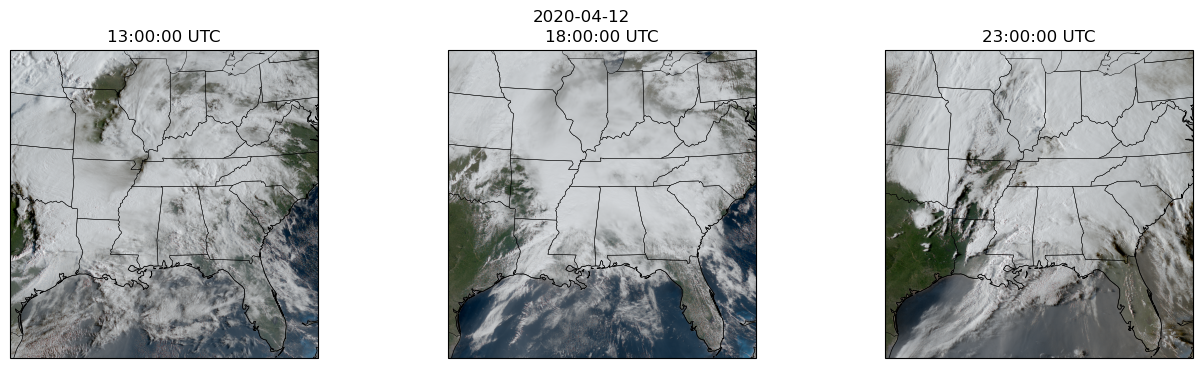

In [56]:
import cartopy.feature as cfeature
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(16, 4))
gs = GridSpec(1, 3)
crs = area.to_cartopy_crs()
ext = area.area_extent
ext = (ext[0], ext[2], ext[1], ext[3])

for ind, time_step in enumerate(time_steps):
    ax = fig.add_subplot(gs[0, ind], projection=crs)
    date = to_datetime(time_step)
    img = np.array(Image.open(f"goes_{date.strftime('%Y%m%d%H%M%S')}.png"))
    ax.imshow(img, extent=ext)
    ax.add_feature(cfeature.STATES, linewidth=0.3)
    ax.coastlines(linewidth=0.5)
    ax.set_title(f"{date.strftime('%H:%M:%S')} UTC")

fig.suptitle("2020-04-12")
